In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.layers import *
import tensorflow.keras as K
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

tf.keras.backend.set_floatx("float64")

In [2]:

def import_data(dataset):
    if dataset == "pets":
        ds,info = tfds.load('oxford_iiit_pet', split='all',with_info=True)
    else:
        ds,info = tfds.load('caltech_birds2010', split='all',with_info=True)
    ds_train = ds.skip(300)
    ds_test = ds.take(300)
    return ds_train,ds_test,info
dataset = "birds"
ds_train_raw,ds_test_raw,info = import_data(dataset)

In [3]:
IMAGE_SIZE = 128
def pre_process_image(record):
    
    image = record["image"]
    image = image / 255
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float64)
    
    seg_image = record["segmentation_mask"]
    seg_image = tf.image.resize(seg_image, (IMAGE_SIZE, IMAGE_SIZE))

    seg_image = tf.cast(seg_image, tf.uint8)
    seg_image = seg_image % 2
    seg_image = tf.cast(seg_image, tf.float64)
    return image,seg_image

resize_train = ds_train_raw.map(pre_process_image)
resize_test = ds_test_raw.map(pre_process_image)

In [4]:

inputs = K.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name="image")

conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(2)(conv1)

conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(2)(conv2)

conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(2)(conv3)

conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(2)(conv4)

conv5 = Conv2D(256, 3, activation='relu', padding='same')(pool4)
conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
pool4 = MaxPooling2D(2)(conv5)

convT1 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv5)

skip1 = concatenate([convT1, conv4])
conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(skip1)
conv6 = Conv2D(128, (3,3), activation='relu', padding='same')(conv6)
convT2 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv6)

skip2 = concatenate([convT2, conv3])
conv7 = Conv2D(64, (3,3), activation='relu', padding='same')(skip2)
conv7 = Conv2D(64, (3,3), activation='relu', padding='same')(conv7)
convT3 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv7)

skip3 = concatenate([convT3, conv2])
conv8 = Conv2D(32, (3,3), activation='relu', padding='same')(skip3)
conv8 = Conv2D(32, (3,3), activation='relu', padding='same')(conv8)
convT4 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv8)

skip4 = concatenate([convT4, conv1])
conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(skip4)
conv10 = Conv2D(16, (1,1), strides=(1,1), padding='same', name = "c10")(conv9)

In [5]:
outputs = Conv2D(1, (1,1), activation="sigmoid", padding="same")(conv10)
model = K.Model(inputs, outputs)

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)

    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):

    return (1-dice_coef(y_true, y_pred))

In [7]:
ds_train = resize_train.batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = resize_test.batch(64).prefetch(tf.data.AUTOTUNE)

In [8]:
import time

optimizer = K.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=diceCoefLoss,metrics=[K.metrics.MeanIoU(num_classes=2),dice_coef])

callbacks = [
    K.callbacks.ModelCheckpoint(f"{dataset}_segmentation.h5", save_best_only=True, monitor="val_dice_coef",mode="max"),
    #K.callbacks.EarlyStopping("val_dice_coef",mode="max")

]

# Train the model, doing validation at the end of each epoch.
epochs = 80


In [9]:
start = time.time()
history = model.fit(ds_train,validation_data=ds_test,epochs=epochs,verbose=2,callbacks=callbacks)
end = time.time()

Epoch 1/80
90/90 - 1528s - loss: 0.6281 - mean_io_u: 0.4295 - dice_coef: 0.3726 - val_loss: 0.4514 - val_mean_io_u: 0.4211 - val_dice_coef: 0.5505 - 1528s/epoch - 17s/step
Epoch 2/80
90/90 - 1209s - loss: 0.4561 - mean_io_u: 0.4503 - dice_coef: 0.5438 - val_loss: 0.4412 - val_mean_io_u: 0.4187 - val_dice_coef: 0.5606 - 1209s/epoch - 13s/step
Epoch 3/80
90/90 - 1240s - loss: 0.4357 - mean_io_u: 0.4210 - dice_coef: 0.5644 - val_loss: 0.3840 - val_mean_io_u: 0.4187 - val_dice_coef: 0.6181 - 1240s/epoch - 14s/step
Epoch 4/80
90/90 - 1203s - loss: 0.3611 - mean_io_u: 0.4197 - dice_coef: 0.6388 - val_loss: 0.3552 - val_mean_io_u: 0.4187 - val_dice_coef: 0.6466 - 1203s/epoch - 13s/step
Epoch 5/80
90/90 - 1015s - loss: 0.3365 - mean_io_u: 0.4220 - dice_coef: 0.6634 - val_loss: 0.3478 - val_mean_io_u: 0.4194 - val_dice_coef: 0.6542 - 1015s/epoch - 11s/step
Epoch 6/80
90/90 - 1008s - loss: 0.3251 - mean_io_u: 0.4240 - dice_coef: 0.6747 - val_loss: 0.3384 - val_mean_io_u: 0.4208 - val_dice_coef: 

KeyboardInterrupt: 

In [ ]:
print(end-start)

In [ ]:

plt.plot(history.history["val_dice_coef"],label= "val_dice_coef")
plt.plot(history.history["dice_coef"],label="train_dice_coef")
plt.legend()

In [10]:
model.load_weights(f"{dataset}_segmentation.h5")

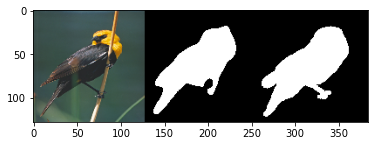

tf.Tensor(0.910456124621764, shape=(), dtype=float64)


In [11]:
image = next(iter(resize_train.shuffle(100).take(1)))

mask = np.repeat(image[1],3).reshape(IMAGE_SIZE,IMAGE_SIZE,3)
pred = np.round(np.repeat(model.predict(image[0].numpy().reshape(-1,128,128,3))[0],3).reshape((IMAGE_SIZE,IMAGE_SIZE,3)))
plt.imshow(np.hstack([image[0],pred,mask]))

# display that image
plt.show()
print(dice_coef(mask,pred))

In [12]:
for split in ["train","test"]:

    if split == "train":
        ds = resize_train
    else:
        ds = resize_test
    dice_coeff_vals = []
    n = int(ds.cardinality())
    for image in iter(ds):

        mask = image[1]
        pred = model.predict(tf.reshape(image[0],(-1,128,128,3)))
        dice_coeff_vals.append(dice_coef(mask,pred[0]))

    dice_coeff_mean = sum(dice_coeff_vals)/n
    dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5
    np.save(f"UNET_{dataset}_{split}",dice_coeff_vals)